# **3.2 Trajectory Optimization**



## **3.2.1 Path vs trajectory search**

* The previous introdructory slides looked at path planning modules used by robotic systems. The path planners operate in a lower resolution state and input space than the actual system. But have the ability to solve complex stratergic decision making (non-convexities) associated with path planning.

* For example whether to go right or left of a set of obstacles thats in the path of a drone when proceeding to the next way point, finding a path to get out of a maze, what is the best route to take going from start to desitination of a road network.

* This is done in a much lower resolution where only a few low resolution samples of all possible states is considered in the planning process.

* For example a map is broken in to a finite set of grids or junctions. And/or only a handful of possible inputs values (turn $30^\circ$ left, turn $30^\circ$ right, go forward) are considered in the path generation process.

* Once such a feasible path is found, this can be further refined to generate a time parameterized trajectory at high resolution to be used by the controller.

* So the role of the trajectory optimizer is to generate $\mathbf{x}_(t)$, $\mathbf{u}(t)$ given a low resolutuion representation of the path to follow. This low resolution path can be in the form of the start state $\mathbf{x}_0$, the end state $\mathbf{x}_f$, any corridors to be within to avoid obstacle, and any constraints which are predefined to achieve a desirable path (platform dynamics, ride comfort, actuator limits etc.)

* Furthermore, the optimizer can consider objectives such as minimizing time incurred, effort incccured, errors incured, or collisiion risk incurred in the solution generation process.

* This notebook introduces you to the main methods for trajectory opimization which can be use to generate desired trajectories for a stabilizing controller like an LQR so it follows a feasible path while adhereing to desirable charachteristics and constraints of the trajectory.





## **4.2.2 The optimal control problem**


* We start with establishing a more general formulation of the control problem which lets us understand the simplifications used by different algorithms used in trajectory optimization. The optimial control problem considering a trajectory of a given system from start time $t_0$ to end time $t_f$ can be defined as follows:

$$ \boxed{\begin{aligned} \underset{\mathbf{u}(t)}{\mathrm{argmin}}
  & ~ J(\mathbf{x}(t),\mathbf{u}(t)) ~~=~~ l_f(\mathbf{x}(t_f)) + \int_{t_0}^{t_f} l(\mathbf{x}(t),\mathbf{u}(t)) dt\\
subject~to~~~ & \dot{\mathbf{x}}(t)=\mathbf{f}(\mathbf{x}(t),\mathbf{u}(t))\\
& \mathbf{x}\in X \subseteq \mathbb{R}^n\\
 & \mathbf{u}\in U \subseteq \mathbb{R}^m\\
& \forall t\in[t_o,t_f]\subset \mathbb{R}
\end{aligned}}
$$

* Here $u(t)$ denotes the input trajectory which is typically the solved variable with input vector dimension $m$, $x(t)$ denotes the state with a state vector dimension $n$, $f(x,u)$ denotes the system dynamics, $X$ and $U$ denotes the set of possible values that the state $x$ and input $u$ can take respectively.
* The cost function includes two components. These include the terminal cost $l_f(\mathbf{x}(t_f))$ which relate to end of trajectory values at final time $t_f$, and the running cost $l(\mathbf{x}(t),\mathbf{u}(t))$ which relate to state and input values assumed during the trajectory $\forall t\in[t_o,t_f]$.
* For path planners we typically limit the search to position states only because the complexities in decision making mainly relate to positional states ( which junctions to take in a road network, which gaps to take for obstacle avoidance etc.)
* For path planners we also had the state space $X$ and input space $U$ divided to a lower resolution representation to maintain a feasible number of solution varaibles. E.g., finite number of positions and feasible inputs connecting these positions in a graph representation.

* This allowed us to use search algorithms (e.g., Djikstrar, A-star, Dynamic programming) to find a solution in that lower resolution domain.




## **3.2.3 Mathematical programming**

* The above optimal control problem should be represented in a compatible form to a mathematical programming library (i.e., optimization library) in the following general form:

$\begin{aligned}
\begin{array}{rl}
                       \min_\alpha \;  &  J(\alpha)
   \\\text{subject to}  \;  &  \alpha \in\mathbb{S}
   \end{array}
   \qquad
   \boxed{
         \begin{array}{ll}
      \text{The real-valued decision variable is}       &\alpha\\
      \text{The real-valued cost function is}           &J(\alpha)\\
      \text{The constraint set is}                      &\mathbb{S}\\
      \text{The optimal } \alpha \text{ that minimizes the cost function is}  &\alpha^*
      \end{array}
      }
\end{aligned}$

* where $\alpha$ is the real-valued decision variable(s), $J(\alpha)$ is the real-valued *cost function*, $\mathbb{S}$ is the constraint set for $\alpha$. Our goal is to find the optimal $\alpha^*$ within the constraint set $\mathbb{S}$, such that $\alpha^*$ minimizes the cost function $J(\alpha)$.


* Generally the above optimization problem with nonlinear cost functions and nonlinear constraints is considered to be non-convex. i.e., there are many local minima in the cost function making the solver prone to be stuck in a local minima.

* When the cost fucntion is linear (i.e, $c^T \alpha$) and the constraint set is a convex region defined by a set of linear constraints (i.e., $A \mathbf{\alpha}\leq b$) then we have a linear programming problems. This is a convex problem with fast efficient solvers.


* When the cost fucntion is quadratic (i.e, $ \alpha^TQ\alpha + c^T \alpha$) and the constraint set is a convex region defined by a set of linear constratints then we have a convex quadratic programming problem. This is another class of convex prgramming with fast efficient solvers.

* There are other classes of convex optimization problems which is discussed in this link (https://en.wikipedia.org/wiki/Convex_optimization). It is desirable to make the mathmatical program efficient and to be a convex formulation. This wil result in the utilization of more efficient and more numerically stable solvers for solution generation.

* Regardless a general nonlinear programming problem is also used in practice with suitable initial conditinos to search a local optimal solution.

* There are three popular methods to convert the OCP to Mathmatical Programming problem.

1. Direct transcription
2. Single/ Multiple shooting
3. Direct collocation

* The code below initiates the libraries used for this notebook, which uses the pydrake pacakge [].

In [ ]:
%%capture
!pip install underactuated
!pip install jaxlie
!sudo apt update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
! rm -r GNCmun
! git clone https://github.com/sendtooscar/GNCmun.git
import sys
path_to_module = 'GNCmun'
sys.path.append(path_to_module)
import utils as utils
import gnc_animations as gnc


## **3.2.4 Direct Transcription**

* Direct transcription method uses the discrete time representation of a system model.

\begin{equation} \begin{array}{c c c}
\dot{\mathbf{x}} = A\mathbf{x} + B\mathbf{u} & \rightarrow & \mathbf{x}_{k+1}=A_k\mathbf{x}_{k}+B_k\mathbf{u}_{k}\\
\dot{\mathbf{x}}=\mathbf{f}(\mathbf{x},\mathbf{u})& \rightarrow  & \mathbf{x}_{k+1}=\mathbf{f}_k(\mathbf{x}_k,\mathbf{u}_k)
\end{array}\end{equation}

* It time discretizes the input and state trajectory to $N$ and $N+1$ samples respectively with a sampling time $dt$.

\begin{equation} \begin{array}{c c c}
t & \rightarrow & \{0,dt,...,t_N\}\\
\mathbf{x}(t) & \rightarrow & \{\mathbf{x}_0,\mathbf{x}_1,...,\mathbf{x}_N\}\\
\mathbf{u}(t) & \rightarrow & \{\mathbf{u}_0,\mathbf{u}_1,...,\mathbf{u}_{N-1}\}\\
\end{array}\end{equation}

* The mathematical program solves for all state and input values of the trajectory using a cost function and constraint set which corresponds to system dynamics and othe constraints related to input and state values of the trajectory.

$$ \boxed{\text{Direct transcription}\\
\begin{aligned} \underset{\mathbf{u}_{0...N-1}, \mathbf{x}_{0...N}}{\mathrm{argmin}}
  & ~ J(\mathbf{x},\mathbf{u}) ~~=~~ l_f(\mathbf{x}_N) + \sum_{k=0}^{N-1}  l(\mathbf{x}_k,\mathbf{u}_k)\\
subject~to~~~ & \mathbf{x}_{k+1}=\mathbf{f}_k(\mathbf{x}_k,\mathbf{u}_k)\\
& \mathbf{x}_0=\mathbf{x}_{start}\\
& \mathbf{x}_N=\mathbf{x}_{end}\\
 & \mathbf{u}_{min} \leq \mathbf{u}_k \leq \mathbf{u}_{max}
 ~~~\forall k=0,...,N-1\subset \mathbb{R}
\end{aligned}}
$$




### **Example 3.1: Direct transcription of a double integrator**

Consider the system model of a double integrator.

The discrete time formulation can be generated as follows using a sampling time dt=0.01.

\begin{equation}
\begin{array}{c c}
\begin{pmatrix} p_{k+1} \\ v_{k+1} \end{pmatrix} &= \begin{pmatrix} 1 &dt \\ 0 &1\end{pmatrix}\begin{pmatrix} p_k \\ v_k \end{pmatrix}+\begin{pmatrix} dt^2/2 \\ dt \end{pmatrix}a\\
\end{array}
\end{equation}


Write a mathematical program to find an optimal path starting at $x = [-2, 0]$ and ending at location $x = [0, 0]$ . The input accelerations $a$ are constrined to be between -1 and 1. Find the time optimal path for the given problem and plot the state vs time and input vs time tragectories. Use N=284 samples to discretize the trajectory.

solver is:  CLP


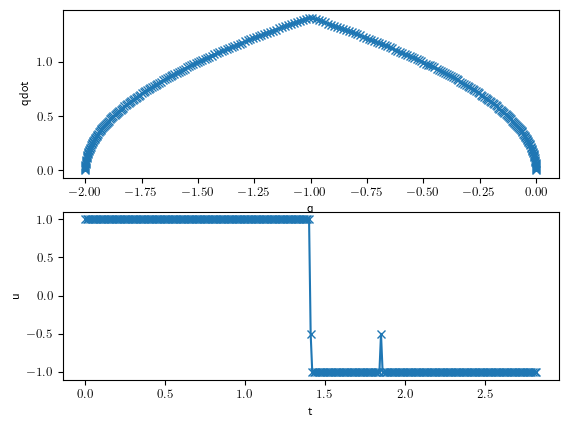

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (
    MathematicalProgram, eq, Solve
)

def double_integrator():
    # 1. Define discrete time dynamical system
    dt = 0.01
    A = np.eye(2) + dt * np.mat("0 1; 0 0")
    B = np.mat([[dt**2/2],[dt]])

    # 2. The mathematical program
    x0 = [-2, 0]
    xf = [0, 0]
    N = 284 # this duration is found manually- can search in a for loop
    prog = MathematicalProgram() #creates a new optimization problem

    # Create decision variables
    u = prog.NewContinuousVariables(1, N - 1, "u") #args 1: dimension of variable, arg 2: number of variables
    x = prog.NewContinuousVariables(2, N, "x")

    # Add constraints
    # True solution: min time(q=-2, qdot=0) = 2√2 = 2.828 seconds.

    for n in range(N - 1):
      prog.AddConstraint( eq(x[:, n + 1], A.dot(x[:, n]) + B.dot(u[:, n]))) # equality constraint equation
      prog.AddBoundingBoxConstraint(-1, 1, u[:, n]) # this allows to set upper and lower bounds in a single statement
      #prog.AddCost(u[0, n] ** 2) # Running cost for minimum effort
      prog.AddCost(1) # Running cost for minimum time

    prog.AddBoundingBoxConstraint(xf, xf, x[:, N -1 ])

    prog.AddBoundingBoxConstraint(x0, x0, x[:, 0]) # starting point constraint as inequality ( prefered)

    # 3. Solve
    result = Solve(prog)
    assert result.is_success(), "Optimization failed"
    print('solver is: ', result.get_solver_id().name())

    # 4. Extract the solution and Visualize
    u_sol = result.GetSolution(u)
    x_sol = result.GetSolution(x)

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(x_sol[0, :], x_sol[1, :], "x-")
    ax[0].set_xlabel("q")
    ax[0].set_ylabel("qdot")
    ax[1].plot(np.arange(0, N - 1) * dt, u_sol.T, "x-")
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("u")


double_integrator()

### **Example 3.2: Direct transcription of a double integrator (Direct transcription class pyDrake)**

For ease of implementation, Pydrake has the direct transcription method to realize direct transcription trajectory planners.  The following example code implements the trajectory planner which indicates the coding method used for the pyDrake package.

solver is:  CLP


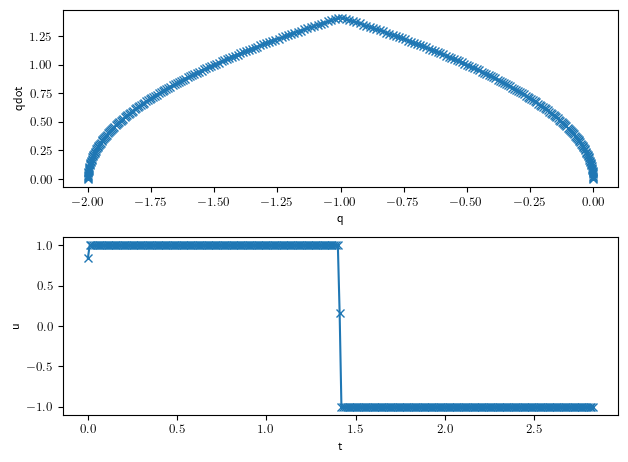

In [ ]:
# dirtran planning of the trajectory - linear system example
# bang bang controller using dirtran
from pydrake.all import (
    DirectCollocation,
    DirectTranscription,
    LinearSystem,
    MathematicalProgram,
    Solve,
    eq,
)

def dirtran_example():
    # 1. Define discrete time dynamical system
    dt = 0.01
    A = np.eye(2) + dt * np.mat("0 1; 0 0")
    B =  np.mat([[dt**2/2],[dt]])
    C = np.eye(2)
    D = np.zeros((2, 1))
    sys = LinearSystem(A, B, C, D, dt)

    # 2. The mathematical program
    N = 284
    x0 = [-2, 0]
    xf = [0, 0]

    dirtran = DirectTranscription(
        system=sys,
        context=sys.CreateDefaultContext(),
        num_time_samples=N
    )

    prog = dirtran.prog()
    prog.AddBoundingBoxConstraint(x0, x0, dirtran.initial_state())
    prog.AddBoundingBoxConstraint(xf, xf, dirtran.final_state())
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] >= -1)
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] <= 1)
    dirtran.AddFinalCost(dirtran.time())

    # 3. Solve
    result = Solve(prog)
    assert result.is_success(), "Optimization failed"
    print('solver is: ', result.get_solver_id().name())

    # 4. Extract the solution and Visualize
    timesteps = dirtran.GetSampleTimes(result)
    x_values = dirtran.GetStateSamples(result)
    u_values = dirtran.GetInputSamples(result)

    fig, ax = plt.subplots(2, 1)
    fig.tight_layout(pad=2.0)
    ax[0].plot(x_values[0, :], x_values[1, :], "x-")
    ax[0].set_xlabel("q")
    ax[0].set_ylabel("qdot")
    ax[1].plot(timesteps, u_values.T, "x-")
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("u")

dirtran_example()

### **Example 3.2: Direct transcription of a pendulum (Direct transcription class)**

Consider the system model of a pendulum with torque input at its joint.


The discrete time formulation can be generated as follows using a sampling time dt=0.01.


Write a mathematical program to find an optimal path starting at the stable equilibrium point $x = [0, 0]$ and ending at the unstable equilibrium $x = [\pi, 0]$ . The input torques $\tau$ are constrined to be between -2 and 2. Find the time optimal path for the given problem and plot the state vs time and input vs time tragectories. Use N=284 samples to discretize the trajectory.

solver is:  SNOPT


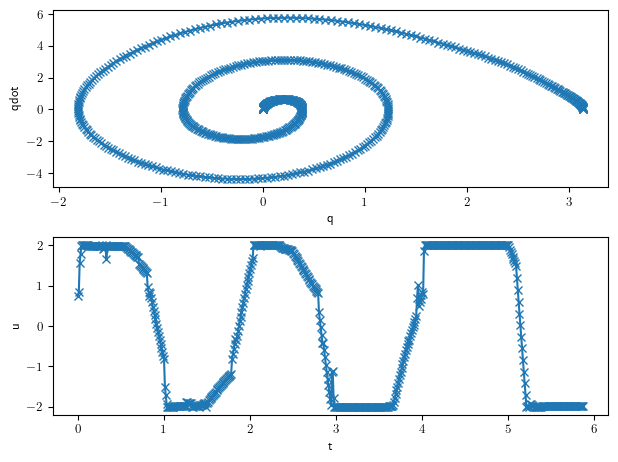

In [ ]:
# dircol planning of the trajectory - linear system example
# bang bang controller using dircol

from pydrake.all import (
    DirectCollocation,
    DirectTranscription,
    LinearSystem,
    Variable,
    MathematicalProgram,
    SymbolicVectorSystem,
    Solve,
    eq,
)
import pydrake.symbolic


def dirtran_example_pend():
    # 1. Define discrete time dynamical system
    # Discrete time dynamics:
    m=1
    g = 9.81
    L = 1

    dt = 0.01

    # Define Symbolic Variables: States = [theta, dtheta]
    th = Variable("th")
    dth = Variable("dth")
    tau = Variable("tau")

    # States and State-space Form:
    states = [th, dth]
    odes   = [dth, -g / L * pydrake.symbolic.sin(th) + tau / (m * L**2)]
    odes_dt = [th + dth*dt, dth -g / L * pydrake.symbolic.sin(th)*dt + tau / (m * L**2)*dt]

    # Define the System:
    pend = SymbolicVectorSystem(state=states, dynamics=odes_dt, output=states, input=[tau], time_period = dt)
    context = pend.CreateDefaultContext()

    # 2. The mathematical program
    N = 588 #minumum time found manually
    x0 = [0.,0.]
    xf = [np.pi,0.]
    torque_limit = 2.0  # N*m.

    dirtran = DirectTranscription(
        system=pend,
        context=context,
        num_time_samples=N
    )

    prog = dirtran.prog()
    prog.AddBoundingBoxConstraint(x0, x0, dirtran.initial_state())
    prog.AddBoundingBoxConstraint(xf, xf, dirtran.final_state())
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] >= -torque_limit)
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] <= torque_limit)
    dirtran.AddFinalCost(dirtran.time()) # minimum time trajectory

    # 3. Solve
    result = Solve(prog)
    assert result.is_success(), "Optimization failed"
    print('solver is: ', result.get_solver_id().name())

    # 4. Extract the solution and Visualize
    timesteps = dirtran.GetSampleTimes(result)
    x_values = dirtran.GetStateSamples(result)
    u_values = dirtran.GetInputSamples(result)

    fig, ax = plt.subplots(2, 1)
    fig.tight_layout(pad=2.0)
    ax[0].plot(x_values[0, :], x_values[1, :], "x-")
    ax[0].set_xlabel("q")
    ax[0].set_ylabel("qdot")
    ax[1].plot(timesteps, u_values.T, "x-")
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("u")


dirtran_example_pend()

## **3.2.5 Single shooting and multiple shooting**


* Single method also uses the discrete time representation of a system model.

\begin{equation} \begin{array}{c c c}
\dot{\mathbf{x}} = A\mathbf{x} + B\mathbf{u} & \rightarrow & \mathbf{x}_{k+1}=A_k\mathbf{x}_{k}+B_k\mathbf{u}_{k}\\
\dot{\mathbf{x}}=\mathbf{f}(\mathbf{x},\mathbf{u})& \rightarrow  & \mathbf{x}_{k+1}=\mathbf{f}_k(\mathbf{x}_k,\mathbf{u}_k)
\end{array}\end{equation}

* It time discretizes the input to $N$ samples with a sampling time $dt$ and relies on the system model to find all state values starting from a known initial condition.  

\begin{equation} \begin{array}{c c c}
t & \rightarrow & \{0,dt,...,t_N\}\\
\mathbf{x}(t) & \rightarrow & \{\mathbf{x}_0,\mathbf{x}_1,...,\mathbf{x}_N\}\\
\mathbf{u}(t) & \rightarrow & \{\mathbf{u}_0,\mathbf{u}_1,...,\mathbf{u}_{N-1}\} \\
where & & \\
&\mathbf{x}_{k+1}=\mathbf{f}_k(\mathbf{x}_k,\mathbf{u}_k)  &\forall k=0,...,N-1\\
\end{array}\end{equation}

* The mathematical program solves for only the input values of the trajectory using a cost function and constraint set which corresponds to system dynamics and other constraints related to input and state values of the trajectory.

$$ \boxed{\text{Singel Shooting}\\
\begin{aligned} \underset{\mathbf{u}_{0...N-1}}{\mathrm{argmin}}
  & ~ J(\mathbf{x},\mathbf{u}) ~~=~~ l_f(\mathbf{x}_N) + \sum_{k=0}^{N-1}  l(\mathbf{x}_k,\mathbf{u}_k)\\
subject~to~~~
& \text{Initialize integration at }\mathbf{x}_0=\mathbf{x}_{start}\\
& ~~~\mathbf{x}_{k+1}=\mathbf{f}_k(\mathbf{x}_k,\mathbf{u}_k)  ~~~\forall k=0,...,N-1\\
& \mathbf{x}_N=\mathbf{x}_{end}\\
 & \mathbf{u}_{min} \leq \mathbf{u}_k \leq \mathbf{u}_{max}
 ~~~\forall k=0,...,N-1
\end{aligned}}
$$

* The stratergy results in the solver relying more on the end of trajectory values of input $u$ to find a solution. As a result it is more advantageous to perform shooting in multiple step, where the intermediate steps of the trajectory (called knots) are introduced as solution variabels. This is termed multiple shooting.

$$ \boxed{\text{Multiple shooting with one knot $x_{knot}$}\\
  \begin{aligned} \underset{\mathbf{u}_{0...N-1},x_{knot}}{\mathrm{argmin}}
  & ~ J(\mathbf{x},\mathbf{u}) ~~=~~ l_f(\mathbf{x}_N) + \sum_{k=0}^{N-1}  l(\mathbf{x}_k,\mathbf{u}_k)\\
subject~to~~~
& \text{Initialize integration at }\mathbf{x}_0=\mathbf{x}_{start}\\
& ~~~\mathbf{x}_{k+1}=\mathbf{f}_k(\mathbf{x}_k,\mathbf{u}_k)  ~~~\forall k=0,...,M-1\\
& \mathbf{x}_M=\mathbf{x}_{knot}\\
& \text{Reinitialize integration at } \mathbf{x}_{knot}\\
& ~~~\mathbf{x}_{k+1}=\mathbf{f}_k(\mathbf{x}_k,\mathbf{u}_k)  ~~~\forall k=M,...,N-1\\
& \mathbf{x}_N=\mathbf{x}_{end}\\
 & \mathbf{u}_{min} \leq \mathbf{u}_k \leq \mathbf{u}_{max}
 ~~~\forall k=0,...,N-1
\end{aligned}}
$$


## **3.2.6 Direct Collocation**

* Direct collocation method approximates the state $x$ and input trajectory $u$ as piecewise polynomials with $N$ knots. The time interval of each polynomial segment is denoted as $h$.

* Note that the number of knots $N$ is much lower than the number of samples used in direct transcription due to larger time intervals and higher order approximaatiom of the interpolation within the time interval.

\begin{equation} \begin{array}{c c c}
t & \rightarrow & \{0,h,...,T\}\\
\mathbf{x}(t) & \rightarrow & \{\mathbf{x}_0,\mathbf{x}_1,...,\mathbf{x}_N\}\\
\mathbf{u}(t) & \rightarrow & \{\mathbf{u}_0,\mathbf{u}_1,...,\mathbf{u}_{N}\}
\end{array}\end{equation}

* For input trajectory a linear interpolation is prefered nd the midpoint of each time interval is used as the collocation point $u_{c,k}$. A collocation point allows to apply continous time system dynamics at the midpoint of a piecewise polynomial trajecotry, which is more accurate and maintains continuity of the generated trajectory.

\begin{equation} \begin{array}{c c c}
\mathbf{t}_{c,k} &=\frac{1}{2}(\mathbf{t}_{k+1}+\mathbf{t}_{k}) \\
\mathbf{u}_{c,k} &=\frac{1}{2}(\mathbf{u}_{k+1}+\mathbf{u}_{k})\\
\end{array}\end{equation}

* For the state trajectory a cubic interpolation is prefered and the midpoint of each time interval is used as the collocation point $x_{c,k}$.

\begin{equation} \begin{array}{c c}
\mathbf{x}_{c,k} &=\frac{1}{2}(\mathbf{x}_{k+1}+\mathbf{x}_{k})+\frac{h}{8}(\mathbf{\dot{x}}_{k}-\mathbf{\dot{x}}_{k+1})\\
\mathbf{\dot{x}}_{c,k} &=\frac{3}{2h}(\mathbf{x}_{k+1}-\mathbf{x}_{k})-\frac{1}{4}(\mathbf{\dot{x}}_{k}+\mathbf{\dot{x}}_{k+1})\\
\end{array}\end{equation}


* Using these collocation points and the knot points the direct collocation method for trajectory optimization is defined as follows:

$$ \boxed{\text{Direct Collocation}\\
\begin{aligned} \underset{\mathbf{u}_{0...N}~\mathbf{x}_{0...N}}{\mathrm{argmin}}
  & ~ J(\mathbf{x},\mathbf{u}) ~~=~~ l_f(\mathbf{x}_N) + \sum_{k=0}^{N-1}  l(\mathbf{x}_k,\mathbf{u}_k)\\
subject~to~~~
& \mathbf{x}_0=\mathbf{x}_{start}\\
& \mathbf{x}_N=\mathbf{x}_{end}\\
& \mathbf{\dot{x}}_{c,k}=\mathbf{f}(\mathbf{x}_{c,k},\mathbf{u}_{c,k})  ~~~\forall k=0,...,N-1\\
 & \mathbf{u}_{min} \leq \mathbf{u}_k \leq \mathbf{u}_{max}
 ~~~\forall k=0,...,N-1
\end{aligned}}
$$



### **Example 3.4: Direct collocation of a double integrator**


Consider the system model of a double integrator.

The discrete time formulation can be generated as follows using a sampling time dt=0.01.

\begin{equation}
\begin{array}{c c}
\begin{pmatrix} p_{k+1} \\ v_{k+1} \end{pmatrix} &= \begin{pmatrix} 1 &dt \\ 0 &1\end{pmatrix}\begin{pmatrix} p_k \\ v_k \end{pmatrix}+\begin{pmatrix} dt^2/2 \\ dt \end{pmatrix}a\\
\end{array}
\end{equation}


Write a mathematical program to find an optimal path starting at $x = [-2, 0]$ and ending at location $x = [0, 0]$ . The input accelerations $a$ are constrined to be between -1 and 1. Find the time optimal path for the given problem and plot the state vs time and input vs time tragectories. Use N=11 knots to discretize the trajectory.

<ipython-input-5-9ca0c12d28a4>:27: DrakeDeprecationWarning: The arguments minimum_timestep and maximum_timestep have been renamed to minimum_time_step and maximum_time_step. This version will be removed on or after 2023-09-01.
  dircol = DirectCollocation(


minimum time = 2.8474739870486263
solver is:  SNOPT


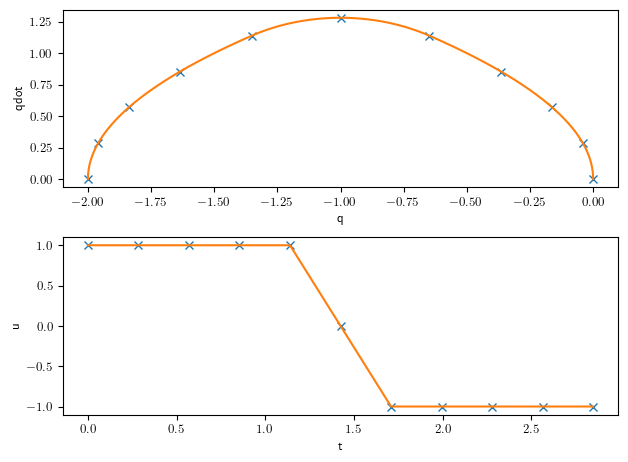

In [ ]:
#dircol planning of the trajectory - linear system example

#0. Environment setup
from pydrake.all import (
    DirectCollocation,
    DirectTranscription,
    LinearSystem,
    MathematicalProgram,
    Solve,
    eq,
)



def dircol_example():
    # 1. System model definition
    A = np.mat("0 1; 0 0")
    B = np.mat("0; 1")
    C = np.eye(2)
    D = np.zeros((2, 1))
    sys = LinearSystem(A, B, C, D)

    # 2. Mathematical program definition
    N = 11
    x0 = [-2, 0]
    xf = [0, 0]
    dircol = DirectCollocation(
        system=sys,
        context=sys.CreateDefaultContext(),
        num_time_samples=N,
        minimum_timestep=0.001,
        maximum_timestep=10 / N,
    )

    prog = dircol.prog()
    prog.AddBoundingBoxConstraint(x0, x0, dircol.initial_state())
    prog.AddBoundingBoxConstraint(xf, xf, dircol.final_state())
    dircol.AddConstraintToAllKnotPoints(dircol.input()[0] <= 1)
    dircol.AddConstraintToAllKnotPoints(dircol.input()[0] >= -1)
    dircol.AddEqualTimeIntervalsConstraints()
    dircol.AddFinalCost(dircol.time())

    # 3. Solve
    result = Solve(prog)
    assert result.is_success(), "Optimization failed"

    # 4. Extract the solution and Visualize
    u_sol = dircol.ReconstructInputTrajectory(result)
    x_sol = dircol.ReconstructStateTrajectory(result)
    print(f"minimum time = {dircol.GetSampleTimes(result)[-1]}")
    print('solver is: ', result.get_solver_id().name())

    #x_solves a polynomial so can be querried for any time t (querreid for 100 samples here)
    X_ref = np.hstack([x_sol.value(t) for t in np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)])
    U_ref = np.hstack([u_sol.value(t) for t in np.linspace(u_sol.start_time(), u_sol.end_time(), 1000)])
    T_ref = np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)

    # knots values of the splines
    T_knots= x_sol.get_segment_times()
    X_knots = x_sol.vector_values(T_knots)
    U_knots = u_sol.vector_values(T_knots)

    fig, ax = plt.subplots(2, 1)
    fig.tight_layout(pad=2.0)
    ax[0].plot(X_knots[0, :], X_knots[1, :], "x")
    ax[0].plot(X_ref[0, :], X_ref[1, :], "-")
    ax[0].set_xlabel("q")
    ax[0].set_ylabel("qdot")
    ax[1].plot(T_knots, U_knots.T, "x")
    ax[1].plot(T_ref, U_ref[0, :], "-")
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("u")


dircol_example()

### **Example 3.5: Direct collocation of a pendulum**


Consider the system model of a pendulum with torque input at its joint.


The discrete time formulation can be generated as follows using a sampling time dt=0.01.


Write a mathematical program to find an optimal path starting at the stable equilibrium point $x = [0, 0]$ and ending at the unstable equilibrium $x = [\pi, 0]$ . The input torques $\tau$ are constrined to be between -2 and 2. Find the time optimal path for the given problem and plot the state vs time and input vs time tragectories. Use N=21 knots to discretize the trajectory to implement a direct collocation trajectory optimizaiton.


<ipython-input-30-ab56da58c4c3>:43: DrakeDeprecationWarning: The arguments minimum_timestep and maximum_timestep have been renamed to minimum_time_step and maximum_time_step. This version will be removed on or after 2023-09-01.
  dircol = DirectCollocation(


solver is:  SNOPT
minimum time = 5.879083577994939


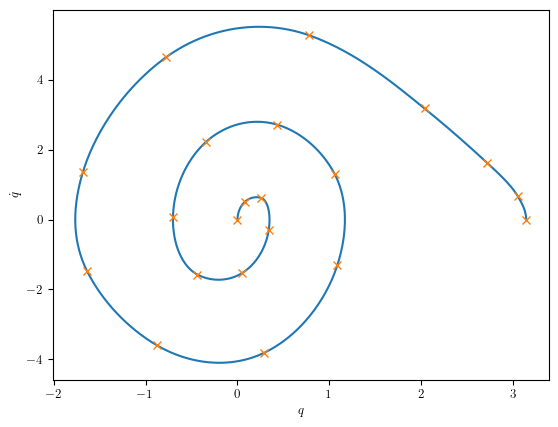

None

Number of frames : 50


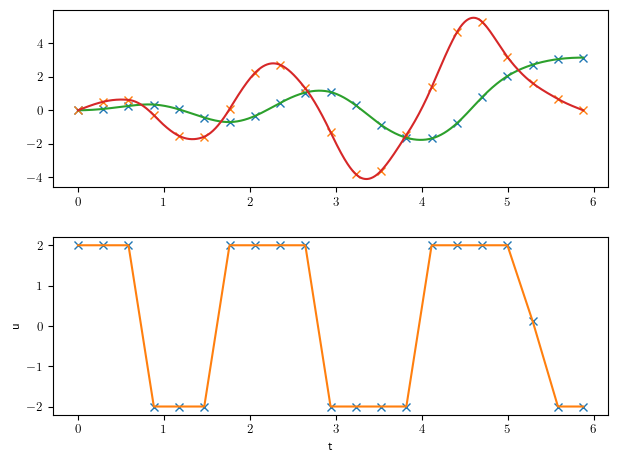

In [ ]:
#0. import libraries
from IPython.display import Markdown, display
import pydrake.symbolic
from pydrake.all import (
    DirectCollocation,
    DirectTranscription,
    LinearSystem,
    MathematicalProgram,
    Solve,
    ToLatex,
    Variable,
    eq,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    FiniteHorizonLinearQuadraticRegulator,
    SymbolicVectorSystem,
    PiecewisePolynomial,
)


def dircol_example_pend():
      # 1. System model definition----------------------------------

      # Parameters:
      m=1; g = 9.81; L = 1.

      # Define Symbolic Variables: States = [theta, dtheta] input -[tau]
      th = Variable("th")
      dth = Variable("dth")
      tau = Variable("tau")

      # States and State-space Form:
      states = [th, dth]
      odes = [dth, -g / L * pydrake.symbolic.sin(th) + tau / (m * L**2)]

      # Define the System:
      pend = SymbolicVectorSystem(state=states, dynamics=odes, output=states, input=[tau])
      context = pend.CreateDefaultContext()

      # 2. Mathematical program-------------------------------------------
      N = 21
      max_dt = 0.5
      N * max_dt
      dircol = DirectCollocation(
              pend,
              context,
              num_time_samples=N,
              minimum_timestep=0.05,
              maximum_timestep=max_dt,
          )
      prog = dircol.prog()

      #time intervals are made equal along trajectory
      dircol.AddEqualTimeIntervalsConstraints()

      # set input limits at each knot point - dircol has to map it to the mathematical program
      torque_limit = 2.0  # N*m.
      u = dircol.input()
      dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
      dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

      # set intial and final state - this is doen on the mathmaticla program
      initial_state = [0.,0.]
      final_state = [np.pi,0.]
      prog.AddBoundingBoxConstraint(initial_state,initial_state,dircol.initial_state())
      prog.AddBoundingBoxConstraint(final_state,final_state,dircol.final_state())

      # optional -  padd running and terminal costs
      R = 10  # Cost on input "effort".
      #dircol.AddRunningCost(R * u[0] ** 2)
      dircol.AddFinalCost(dircol.time())

      # set the trajectory to optimze -  initial condition
      initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0.0, 4.0], [initial_state, final_state])
      dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

      # 3. Solve-----------------------------------------------
      result = Solve(prog)
      assert result.is_success()
      print('solver is: ', result.get_solver_id().name())
      print(f"minimum time = {dircol.GetSampleTimes(result)[-1]}")

      # 4. Result extraction and visualization-----------------------------------------------
      x_sol = dircol.ReconstructStateTrajectory(result)
      u_sol = dircol.ReconstructInputTrajectory(result)

      #x_solves a polynomial so can be querried for any time t
      X_ref = np.hstack([x_sol.value(t) for t in np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)])
      U_ref = np.hstack([u_sol.value(t) for t in np.linspace(u_sol.start_time(), u_sol.end_time(), 1000)])
      T_ref = np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)

      # knots values of the splines
      T_knots= x_sol.get_segment_times()
      X_knots = x_sol.vector_values(T_knots)
      U_knots = u_sol.vector_values(T_knots)

      #plot the phase plane plot
      fig, ax = plt.subplots()
      ax.set_xlabel("$q$")
      ax.set_ylabel("$\dot{q}$")
      ax.plot(X_ref[0, :], X_ref[1, :],'-')
      ax.plot(X_knots[0,:], X_knots[1,:],'x')
      display(plt.show())

      #plot the state and input trajectory
      fig, ax = plt.subplots(2, 1)
      fig.tight_layout(pad=2.0)
      ax[0].plot(T_knots, X_knots.T, "x")
      ax[0].plot(T_ref, X_ref[0, :], "-")
      ax[0].plot(T_ref, X_ref[1, :], "-")
      ax[1].set_xlabel("t")
      ax[1].set_ylabel("x")

      ax[1].plot(T_knots, U_knots.T, "x")
      ax[1].plot(T_ref, U_ref.T, "-")
      ax[1].set_xlabel("t")
      ax[1].set_ylabel("u")


      # make the solution as a list for animation
      X=[];U=[];T=[];
      for t in np.linspace(u_sol.start_time(), u_sol.end_time(), 1000):
        T.append(t)
        X.append(x_sol.value(t)[:,0])
        U.append(u_sol.value(t)[:,0])

      dt = T[1]
      param = np.array([m,L,g,dt])
      anim = gnc.animate_isl_pendulum(X,U,T,param,20,3) # this is animating the reference trajectory
      return anim, x_sol, u_sol, X,U,T, X_ref, U_ref, T_ref


anim, x_sol, u_sol, X,U,T, X_ref, Uref, T_ref = dircol_example_pend()
anim


## **3.2.7 Trajectory Tracking control**

* The above visualization is of the planned path $x_{ref}(t)$ found by the optimizer. This is the expected path for the system to follow when $u_{ref}(t)$ is applied on the system in open loop. However, an open loop stratergy like this is doomed to fail because of the lack of feedback stabilization.


* For the above example it is possible to let an LQR take over once the open loop trajectory is capable of bringing the pendulum to its region of attraction. But such a controller does not address the cases when $x$ deviated from the reference trajectory $x_{ref}$.

* Whats needed is a trajectory tracking controller which brings the tracking error $\Delta x=x(t)-x_{ref}(t)$ to a very low value within the dutration of the trajectory.

* Trajacory tracking is performs using two main methods discussed below:

  * **Finite time LQR** - make an LQR controller capable of tracking a provided trajectory within the finite duration fo the trajectory.
  * **Model predictive control** -  Implement a trajectory planner to replan the trajectory at the every time step and apply the immediate next control action calculated by the optimizer.


In [ ]:
#@title --
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean_x, mean_y , cov, ax, n_std=3, **kwargs):
    """
    Create a plot of the covariation confidence ellipse op `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data

    Returns
    -------
    float: the Pearson Correlation Coefficient for `x` and `y`.

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties

    author : Carsten Schelp
    license: GNU General Public License v3.0 (https://github.com/CarstenSchelp/CarstenSchelp.github.io/blob/master/LICENSE)
    """
    #if x.size != y.size:
    #    raise ValueError("x and y must be the same size")

    #cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ellipse = Ellipse(xy=(mean_x, mean_y),
                  width=lambda_[0]*n_std*2, height=lambda_[1]*n_std*2,
                  angle=np.rad2deg(np.arctan2(v[0, 0],v[0,1])), **kwargs)

    ax.add_patch(ellipse)

    # render plot with "plt.show()".

## **3.2.8 Finitie Time LQR**

In [ ]:
%%capture
!pip install control

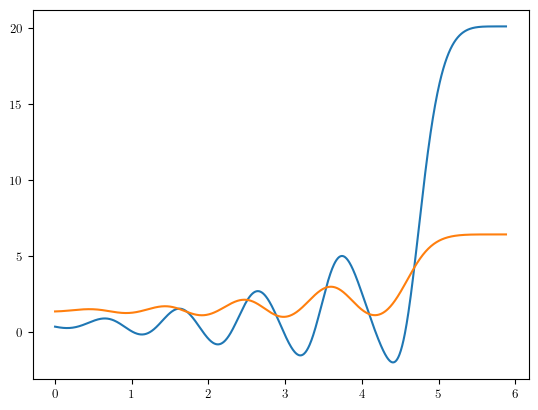

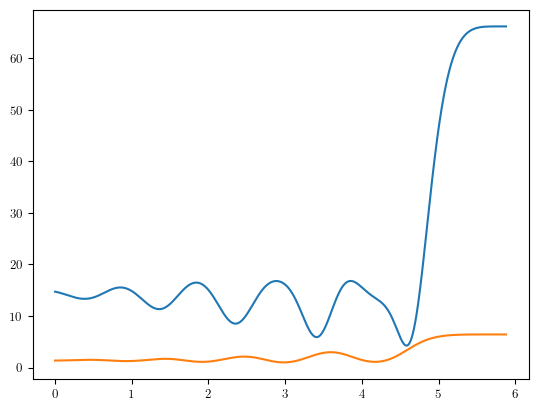

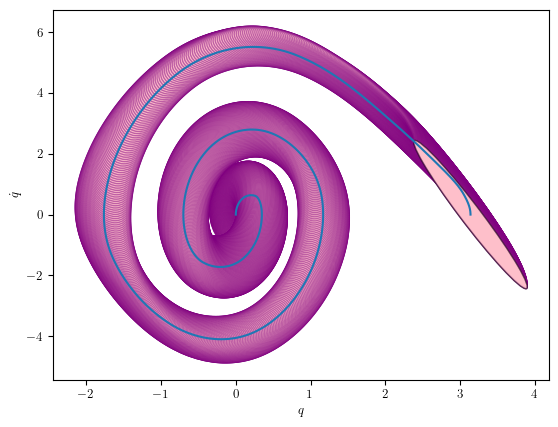

None

In [ ]:
# getting the stabilizing gains for ths system

from pydrake.all import Jacobian, Evaluate
import control as ct


# Parameters:
m=1; g = 9.81; L = 1.

# Define Symbolic Variables: States = [theta, dtheta] input -[tau]
th = Variable("th")
dth = Variable("dth")
tau = Variable("tau")

# States and State-space Form:
states = [th, dth]
odes = [dth, -g / L * pydrake.symbolic.sin(th) + tau / (m * L**2)]

# Define the System:
pend = SymbolicVectorSystem(state=states, dynamics=odes, output=states, input=[tau])
context = pend.CreateDefaultContext()

#Define system model and find stabilizing LQR for theta = pi
A = Jacobian(odes,states)
B = Jacobian(odes,np.array([tau]))
A = Evaluate(A,{th:np.pi,dth:0.})
B = Evaluate(B,{th:np.pi,dth:0.})
Q = np.diag([10.0, 1.0])
R = np.diag([1.0])
Kc, Sc, Ec = ct.lqr(A,B,Q,R)

#Define finite time LQR for the rest of the trajectory with Qf=Sc
options = FiniteHorizonLinearQuadraticRegulatorOptions()
options.x0 = x_sol #ref states
options.u0 = u_sol #ref input
options.Qf = Sc  #final cost
options.input_port_index = pend.get_input_port(0).get_index()
results = FiniteHorizonLinearQuadraticRegulator(
        pend,
        context,
        t0=options.u0.start_time(),
        tf=options.u0.end_time(),
        Q=np.diag([10.0, 1.0]),
        R=np.eye(1),
        options=options,
)


# Visualize resulting K and S values.
K_ref = np.hstack([results.K.value(t).T for t in T])
S_ref = np.vstack( [results.S.value(t).diagonal().T for t in T])

plt.figure()
plt.plot(T_ref, K_ref.T)

plt.figure()
plt.plot(T_ref, S_ref)

#plot example region of attraction (\rho =0.3)
fig, ax = plt.subplots()
ax.set_xlabel("$q$")
ax.set_ylabel("$\dot{q}$")
ax.plot(X_ref[0, :], X_ref[1, :],'-')

for t in T_ref:
  confidence_ellipse(x_sol.value(t)[0,0] , x_sol.value(t)[1,0] , results.S.value(t), ax, n_std=0.3, alpha=0.5, facecolor='pink', edgecolor='purple', zorder=0)
confidence_ellipse(np.pi, 0.0 , Sc , ax, n_std=0.3, alpha=0.5, facecolor='pink', edgecolor='black', zorder=0)
display(plt.show())



Number of frames : 75


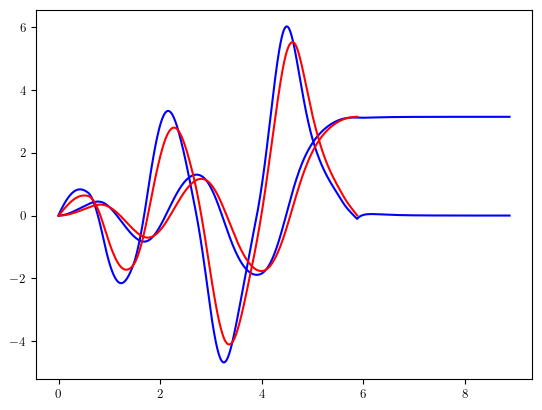

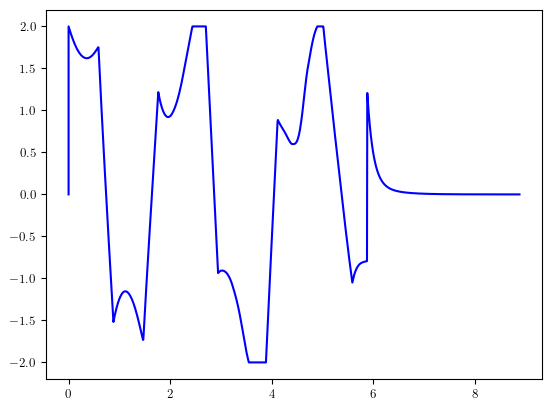

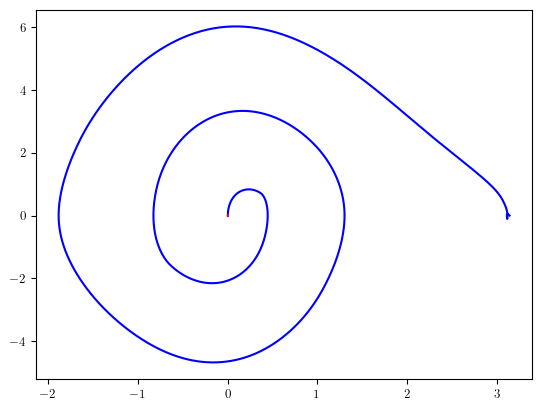

In [ ]:
# simulating the pendulum using the dircol u values

# Pendulum simulation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import control as ct

rc('animation', html='jshtml')

# We maintain the following numpy vectors  dx = f(x,u,t,param,w) , y = h(x,nu,param)

# 1. initialization - init_parameters()
m, L, g = 0.9, 0.8, 9.81   # Mass (kg), pendulum length (m), acceleration due to gravity (m.s-2).
dt = T[1]
i = 0   # data point iterator
theta0, v0 = np.radians(30), 0.1 # Initial angular displacement (rad), tangential velocity (m.s-1)
theta0, v0 = np.radians(0), 0.0 # Initial angular displacement (rad), tangential velocity (m.s-1)
t_end = T[-1]; # 2 times period
X_act = [];  # Variables for data acquisition
T_act = [];
U_act = [];
param = np.array([m,L,g,dt,theta0,v0])  # the parameter vector
x = np.array([theta0, v0]) # state vector
X_act.append(x)
T_act.append(0.)
U_act.append(0.)
t = 0.0; # time variable

# Define the system simulation function (with integration)
def pendulum_sys_model(x,t,u,param):
  RK4 = True
  L = param[1]
  g = param[2]
  dt = param[3]

  def func(x,u,t):
    theta = x[0]
    omega = x[1]
    tau = u
    dtheta = omega
    domega = -g/L*np.sin(theta) + tau / (m * L**2)
    dx = np.array([dtheta, domega])
    return dx

  if RK4:
    dt
    k1 = func(x, u, t)
    k2 = func(x + dt/2. * k1, u, t + dt/2.)
    k3 = func(x + dt/2. * k2, u, t + dt/2.)
    k4 = func(x + dt    * k3, u, t + dt)
    x = x + dt / 6. * (k1 + 2. * k2 + 2. * k3 + k4)
    return x
  else:
    x = x + func(x,u,t)*dt  #fwd euler integration

  return x

# 2. simulation
# apply finite tome lqr for tracking
for t in np.arange(0,t_end,dt):
  i = i + 1
  u = u_sol.value(t)[0,0]  - results.K.value(t)[0,:] @ (x-x_sol.value(t)[:,0])  # FTLQR trajectory tracking
  #u = u_sol.value(t)[0,0] #This is the open loop control case ( unstable for perturbations in system model)
  u = max(min(2, u), -2) # input saturation
  x = pendulum_sys_model(x,t,u,param) # system simulation using forward euler

  #Data Aquisition
  X_act.append(x)
  T_act.append(t)
  U_act.append(u)

#stabilizing K for the upright position
Kc, S, E = ct.lqr(A,B,Q,R)

#apply stabilizing K once upright is reached
for t in np.arange(t_end,t_end+3,dt):
  i = i + 1
  u = -Kc[0,:] @ (x - x_sol.value(t_end)[:,0])  # this is the LQR stabilizing gain
  #u = 0.0 #This is the open loop control case (unstable)
  u = max(min(2, u), -2)
  x = pendulum_sys_model(x,t,u,param) # system simulation using forward euler

  #Data Aquisition
  X_act.append(x)
  T_act.append(t)
  U_act.append(u)

# 3. visualization functions
fig1 = plt.figure()
p = plt.plot(T_act, X_act, color='b')
p = plt.plot(T, X_ref.T, color='r')

fig1 = plt.figure()
p = plt.plot(T_act, U_act, color='b')

fig2 = plt.figure()
theta_act = np.hstack([x[0] for x in X_act])
omega_act = np.hstack([x[1] for x in X_act])
theta_ref = np.hstack([x[0] for x in X_ref])
omega_ref = np.hstack([x[1] for x in X_ref])
p = plt.plot(theta_act, omega_act, color='b')
p = plt.plot(theta_ref, omega_ref, color='r')


anim = gnc.animate_isl_pendulum(X_act,U,T_act,param,10,3)
anim

## **Excercise 3.1 - Direct collocation of a 2D quadcopter**

The following code defines a system model for a 2D quadcopter. The quadcopter is reqreuid to go from start pose
$(px=-1,py=2,\theta=10^{\circ})$ to end pose $(px=5,py=-2,\theta=0^{\circ})$ using a minimal effort optimality for the trajectory. Use a running cost of $u^TRu$ with $R=I_2$. Complete the (#ENTER YOUR MODIFICATIONS HERE) secction to implement a direct collocation type trajectory planner for the task. The quadcopter has a max thrust of $5*m*g$ and it cannot produce reverse trhust. Also assume the ground leven is at $y=-3$. and there is a wall to the left of the diagram at $x=-3$ meters.

Complete the mathematical program and plot the (x,y) trajectory of the generated path.

In [ ]:
#@title --

import matplotlib as mpl
from IPython.display import HTML
def animate_2Dquad(X,U,T,param,robot_scale=1.5,frame_num=100,speedup=10,tail=100):
  # X, U , T are the state input and time vectors
  #robot_scale =0.5;
  dt=param[0]
  fig = plt.figure()
  ax = fig.add_subplot(aspect='equal')
  ax.set_xlim(-2.2, 6.2)
  ax.set_ylim(-2.2, 2.2)
  # from svg in onshape- https://cad.onshape.com/documents/0025875f07c2427c8fe3436c/w/702252847b1dcbe22315c39c/e/616f7d899244a29ab83281b5?renderMode=0&uiState=6450db4be0083461f05ccb8a
  drone_points = np.array([[0,0.034],[0.058,0.034],[0.120,0.020],[0.261,0.020],[0.261,0.051],[0.254,0.051],[0.228,0.030],[0.215,0.030],[0.075,0.054],[0.467,0.054],[0.319,0.030],[0.312,0.030],[0.285,0.049],[0.285,0.051],[0.278,0.051],[0.278,0.020],[0.319,0.020],[0.337,0],[0.319,-0.017],[0.149,-0.017],[0.120,-0.044],[0.066,-0.044],[0.058,-0.069],[0,-0.069]])
  drone_points_mirror =  np.flip(drone_points @ np.array([[-1 , 0], [ 0, 1]]), axis=0) #np.flip(-drone_points, axis=0);
  drone_points_all = np.append(drone_points , drone_points_mirror, axis=0)
  triangle = ax.add_patch(plt.Polygon(drone_points_all*robot_scale, True))
  line, = ax.plot([0, 0,3], [0, -1,5], lw=1, c='c', alpha=0.5) # draw a line
  line.set_data([0],[0])
  transform = mpl.transforms.Affine2D().rotate_deg(-45) + mpl.transforms.Affine2D().translate(-5,-5)
  triangle.set_transform(transform+ax.transData)

  # determine skip amount from number of frames
  #frame_num =300
  #speedup =2
  #tail = 100 # this should be passes to the function
  skip = np.floor(len(X)/frame_num)
  if skip < 1:
    skip=1
    frame_num = len(X)
  skip=int(skip)
  out = display(progress(0, 100), display_id=True)
  #print(skip)

  def animate(i):
    #print(i,end=' ')
    out.update(progress(i/frame_num*100, 100))
    transform = mpl.transforms.Affine2D().rotate(X[skip*i][4]) + mpl.transforms.Affine2D().translate(X[skip*i][0],X[skip*i][2])
    triangle.set_transform(transform+ax.transData)
    if i>1:
      if skip*i>tail:
        Xtemp= np.array(X[skip*i-tail:skip*i])
        line.set_data(Xtemp[:,0],Xtemp[:,2])
      else:
        Xtemp= np.array(X[0:skip*i])
        line.set_data(Xtemp[:,0],Xtemp[:,2])

  ani = animation.FuncAnimation(fig, animate, frames=frame_num, repeat=True, interval=int(dt*1000*skip/speedup)) # interval determines speed in ms
  print("Number of frames :",frame_num)
  plt.close()
  return ani


def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

<ipython-input-84-c00961323168>:48: DrakeDeprecationWarning: The arguments minimum_timestep and maximum_timestep have been renamed to minimum_time_step and maximum_time_step. This version will be removed on or after 2023-09-01.
  dircol = DirectCollocation(


solver is:  SNOPT
minimum time = 10.0


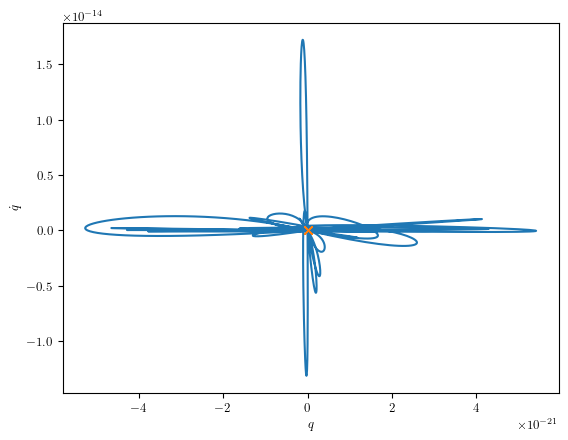

None

<ipython-input-65-b048e087686b>:17: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  triangle = ax.add_patch(plt.Polygon(drone_points_all*robot_scale, True))


Number of frames : 50


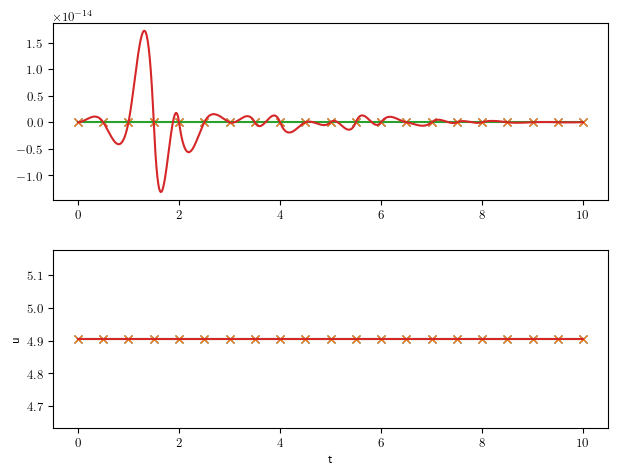

In [ ]:
#0. import libraries
from IPython.display import Markdown, display
import pydrake.symbolic
from pydrake.all import (
    DirectCollocation,
    DirectTranscription,
    LinearSystem,
    MathematicalProgram,
    Solve,
    ToLatex,
    Variable,
    eq,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    FiniteHorizonLinearQuadraticRegulator,
    SymbolicVectorSystem,
    PiecewisePolynomial,
)

def dircol_example_2dquad():
      # 1. Define system model:
      # ------Vehicle Parameters-------------
      dt = 0.01; m  = 1.0; g  = 9.81; L = 1.0; r =L; I = 1.0

      # --------Symbolic Variables (x,u)------
      px = Variable("px")
      dpx = Variable("dpx")
      py = Variable("py")
      dpy = Variable("dpy")
      th = Variable("th")
      dth = Variable("dth")
      f1 = Variable("f1")
      f2 = Variable("f2")

      # --------States and State-space Model----
      x = [px, dpx, py, dpy, th, dth]
      u = [f1, f2]
      dx = [  x[1],                           # pxdot = vx
            -(u[0] + u[1]) * pydrake.symbolic.sin(x[4])/m,  # vxdot = -(u1 + u2)sin(theta)/m
            x[3],                           # pydot = vy
            (u[0] + u[1]) * pydrake.symbolic.cos(x[4])/m - g,
            x[5],
            (u[0] - u[1]) * r / I ]
      quad = SymbolicVectorSystem(state=x, dynamics=dx, output=x, input=u)

      #2.------- Mathematical program ------------
      N = 21
      max_dt = 0.5
      dircol = DirectCollocation(
            quad,
            quad.CreateDefaultContext(),
            num_time_samples=N,
            minimum_timestep=0.01,
            maximum_timestep=max_dt,
        )
      prog = dircol.prog()


     #-----------ENTER YOUR MODIFICATIONS HERE-----------------------
      dircol.AddEqualTimeIntervalsConstraints()

      # set input limits at each knot point - dircol has to map it to the mathematical program
      torque_limit = m * g * 5  # 20N
      u = dircol.input()
      x = dircol.state()
      dircol.AddConstraintToAllKnotPoints(x[0] ==0.0 )
      dircol.AddConstraintToAllKnotPoints(x[2] ==0.0 )

      #Set intial and final state- this is doen on the mathmaticla program
      initial_state = [0.,0.,0.,0.,0.,0.]
      final_state = [0.,0.,0.,0.,0.,0.]
      prog.AddBoundingBoxConstraint(initial_state,initial_state,dircol.initial_state())
      prog.AddBoundingBoxConstraint(final_state,final_state,dircol.final_state())

      #Add running cost and terminal costs


      #-----------DO NOT CHANGE FROM HERE-----------------------

      # set the trajectory to optimze -  initial condition
      initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0.0, 10.0], np.column_stack((initial_state, final_state)))
      dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

      # 3. Solve-----------------------------------------------
      result = Solve(prog)
      assert result.is_success()
      print('solver is: ', result.get_solver_id().name())
      print(f"minimum time = {dircol.GetSampleTimes(result)[-1]}")

      # 4. Result extraction and visualization-----------------------------------------------
      x_sol = dircol.ReconstructStateTrajectory(result)
      u_sol = dircol.ReconstructInputTrajectory(result)

      #x_solves a polynomial so can be querried for any time t
      X_ref = np.hstack([x_sol.value(t) for t in np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)])
      U_ref = np.hstack([u_sol.value(t) for t in np.linspace(u_sol.start_time(), u_sol.end_time(), 1000)])
      T_ref = np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)

      # knots values of the splines
      T_knots= x_sol.get_segment_times()
      X_knots = x_sol.vector_values(T_knots)
      U_knots = u_sol.vector_values(T_knots)

      #plot the phase plane plot
      fig, ax = plt.subplots()
      ax.set_xlabel("$q$")
      ax.set_ylabel("$\dot{q}$")
      ax.plot(X_ref[0, :], X_ref[2, :],'-')
      ax.plot(X_knots[0,:], X_knots[2,:],'x')
      display(plt.show())

      #plot the state and input trajectory
      fig, ax = plt.subplots(2, 1)
      fig.tight_layout(pad=2.0)
      ax[0].plot(T_knots, X_knots[0, :].T, "x")
      ax[0].plot(T_knots, X_knots[2, :].T, "x")
      ax[0].plot(T_ref, X_ref[0, :], "-")
      ax[0].plot(T_ref, X_ref[2, :], "-")
      ax[1].set_xlabel("t")
      ax[1].set_ylabel("x")

      ax[1].plot(T_knots, U_knots.T, "x")
      ax[1].plot(T_ref, U_ref.T, "-")
      ax[1].set_xlabel("t")
      ax[1].set_ylabel("u")


      # make the solution as a list for animation
      X=[];U=[];T=[];
      for t in np.linspace(u_sol.start_time(), u_sol.end_time(), 1000):
        T.append(t)
        X.append(x_sol.value(t)[:,0])
        U.append(u_sol.value(t)[:,0])

      dt = T[1]
      param= np.array([dt])
      anim = animate_2Dquad(X,U,T,param,1.0,50,2,150)
      return anim


anim = dircol_example_2dquad()
anim




## **3.2.9. Model Predictive control**

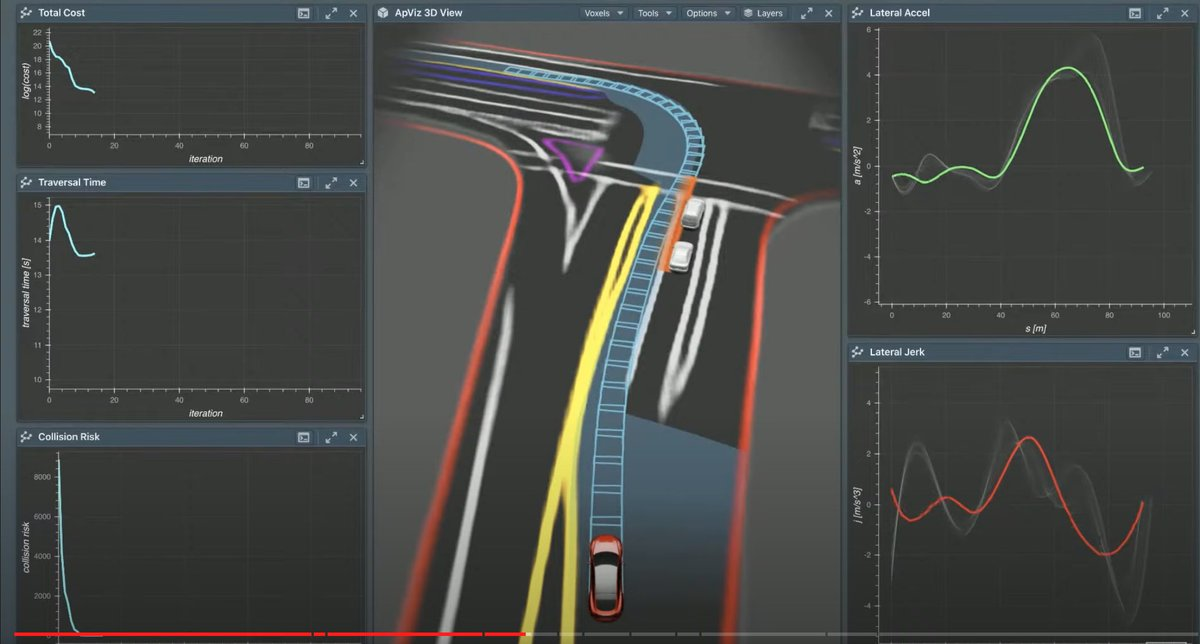

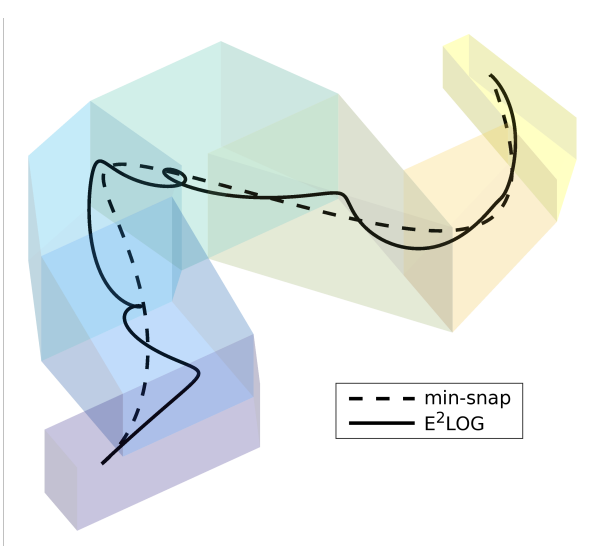

Trajopt+LQR
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7039413&casa_token=jg1aZk2K47wAAAAA:GiSK89yh5g2ML_KEZftNg4iHx2ljumXozYmqLcYnFYEcQWXSrEVajkjN7YYPLjvnkmv1nisbgQ&tag=1


Quadratic program - MPC
https://youtu.be/geqip_0Vjec